# Compute distance to Coma

We can do this one of two ways:
 * Compare the y-intercept from this calibration with that from the final fit
 * Compute the average distance modulus form all of the galaxies within the cluster

In [1]:
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib.pyplot as plt

In [2]:
h = 1
H0 = 100*h

c = 3e5

## Method 1: Compare y-intercepts

From the slope calibration (`Coma-Fuji_KAD.ipynb`), we found a y-intercept for the Coma cluster of
\begin{equation}
  12.87^{+0.49}_{-0.62} = 12.87\pm 0.59
\end{equation}

From the zero-point calibration (`fuji_zero-point_KAD.ipynb`), we found a y-intercept for the entire TFR of
\begin{equation}
  -22.00\pm 0.16
\end{equation}

In [3]:
b_coma = 12.87
b_coma_err = 0.59

ZP = -22.00
ZP_err = 0.16

mu_coma = b_coma - ZP
mu_coma_err = np.sqrt(b_coma_err**2 + ZP_err**2)

In [21]:
# Convert to distance
d_coma = 10*10**(mu_coma/5) # pc/h
d_coma_Mpc = d_coma/1e6

d_coma_err = d_coma*0.2*np.log(10)*mu_coma_err
d_coma_err_Mpc = d_coma_err/1e6

print(f'Distance modulus to Coma: {mu_coma:.2f} +/- {mu_coma_err:.2f}')
print(f'Distance to Coma: {d_coma_Mpc:.2f} +/- {d_coma_err_Mpc:.2f} Mpc/h')

Distance modulus to Coma: 34.87 +/- 0.61
Distance to Coma: 94.19 +/- 26.52 Mpc/h


## Method 2: Average of all distance moduli

In [5]:
SGA_TF = Table.read('SGA_fuji_TFR_moduli.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_err,R_ABSMAG_SB26,R_ABSMAG_SB26_err,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_err,mu_TF,mu_TF_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407323,0.0054267743,0.0054291883,0.0051505533,0.005328927,0.005367155,0.005074676,0.005267603,0.0053163357,16.432898,0.27237165,3.4572394,5.399334,1.6520585,15.889806,0.2892297,2.7702796,4.85128,0.7334321,15.531683,0.31152296

### Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [6]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [7]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]

In [8]:
# Data table #2 from Tully et al. (2013)
hdu = fits.open('../Tully13-Table2.fit')
table2 = Table(hdu[1].data)
hdu.close()

table2[:5]

_RAJ2000,_DEJ2000,N1,__Dist_,__DM_,__Err_,N2,GLON,GLAT,SGLON,SGLAT,GMT,__Bmag_,__Kmag_,__HV_,__GV_,__Vls_,__Vcmb_,__Vcmba_,sigma,__PV_,__PVa_,Group,Ng,_2M__,PGCb,GName,_2M,Simbad,NED,recno
float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,int32,int32,int32,int32,int32,int16,int32,int32,int16,int16,int16,int32,str10,str2,str6,str3,int32
266.404996,-28.936172,16,0.01,14.5,0.02,20,0.0,0.0,185.7861,42.3103,1,-6.0,-9.0,51,26,13,91,91,64,90,90,223,16,0,17223,Galaxy,2M,Simbad,NED,1
15.693346,36.392682,39,0.76,24.4,0.01,41,125.479,-26.423,322.2989,9.4579,2,3.4,0.68,-213,-49,17,-485,-484,156,-541,-547,222,39,0,2557,NGC0224,2M,Simbad,NED,2
149.896678,-12.831016,4,1.37,25.68,0.03,4,251.1365,32.2601,120.502,-42.5472,10,9.75,9.29,347,153,103,690,691,23,589,589,227,4,0,29128,NGC003109,2M,Simbad,NED,3
139.011477,52.840941,1,1.37,25.68,0.1,1,164.6636,42.8855,47.6118,-15.0125,10,13.75,11.5,-29,17,45,130,130,0,28,28,0,579,0,26142,UGC4879,2M,Simbad,NED,4
243.448636,54.37081,1,1.91,26.41,0.08,1,83.8788,44.4092,56.0935,40.37,10,16.69,12.9,-139,44,78,-121,-120,0,-262,-268,230,1,0,2801026,KKR25,2M,Simbad,NED,5


In [9]:
Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = Coma_coords.match_to_catalog_sky(group_coords)

V_Coma = table2['__HV_'][idx][0]

#### Calculate the projected distance between the Coma cluster and each galaxy

In [10]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_Coma_angle = (R2t_Coma/(V_Coma/H0))*u.radian

In [11]:
SGA_coords = SkyCoord(SGA_TF['RA'], SGA_TF['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [12]:
SGA_in_Coma1 = (sep < 1.5*R2t_Coma_angle) & (SGA_TF['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA_TF['Z_DESI']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (sep < 3*R2t_Coma_angle) & (SGA_TF['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA_TF['Z_DESI']*c < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA_TF['SGA_ID'][SGA_in_Coma]

SGA_TF_Coma = SGA_TF[SGA_in_Coma]
################################################################################

print('SGA galaxies in Coma with distance moduli:', len(SGA_ID_in_Coma))

SGA galaxies in Coma with distance moduli: 110


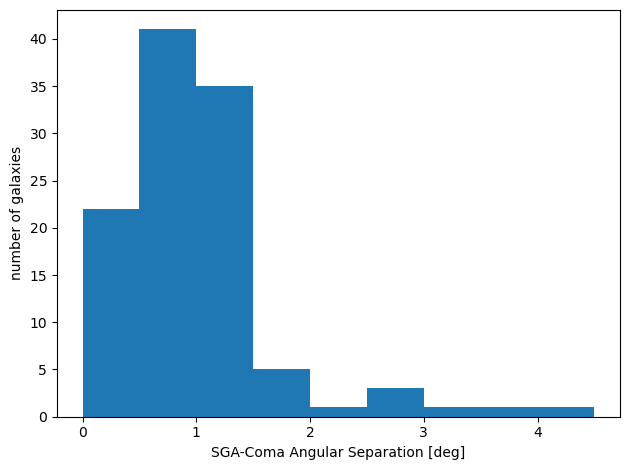

In [13]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

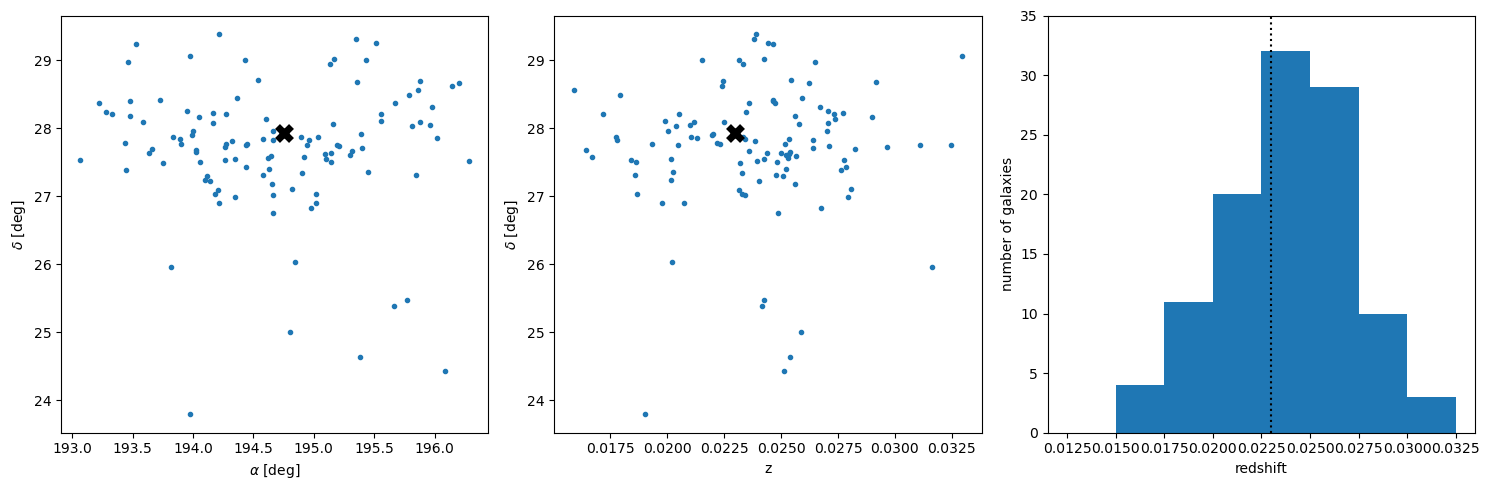

In [14]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(SGA_TF_Coma['RA'], SGA_TF_Coma['DEC'], '.')
# plt.plot(SGA_TF_Coma['RA'][np.in1d(SGA_TF_Coma['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
#          SGA_TF_Coma['DEC'][np.in1d(SGA_TF_Coma['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
#          'o')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(SGA_TF_Coma['Z_DESI'], SGA_TF_Coma['DEC'], '.')
# plt.plot(SGA_TF_Coma['Z_DESI'][np.in1d(SGA_TF_Coma['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
#          SGA_TF_Coma['DEC'][np.in1d(SGA_TF_Coma['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
#          'o')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(SGA_TF_Coma['Z_DESI'], bins=np.arange(0.0125, 0.035, 0.0025))
# plt.hist(SGA_TF_Coma['Z_DESI'][np.in1d(SGA_TF_Coma['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
#          bins=np.arange(0.0125, 0.035, 0.0025))
plt.vlines(V_Coma/c, 0, 85, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=35);

### Calculate average distance modulus

We will use the weighted mean,
\begin{equation}
  \overline{\mu} = \frac{\sum_i w_i \mu_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [15]:
weights = 1./SGA_TF_Coma['mu_TF_err']**2

mu_coma_avg = np.average(SGA_TF_Coma['mu_TF'], weights=weights)
mu_coma_avg_err = np.sqrt(1./np.sum(weights))

In [20]:
# Convert to distance
d_coma_avg = 10*10**(mu_coma_avg/5) # pc/h
d_coma_avg_Mpc = d_coma_avg/1e6

d_coma_avg_err = d_coma_avg*0.2*np.log(10)*mu_coma_avg_err
d_coma_avg_err_Mpc = d_coma_avg_err/1e6

print(f'Distance modulus to Coma: {mu_coma_avg:.3f} +/- {mu_coma_avg_err:.3f}')
print(f'Distance to Coma: {d_coma_avg_Mpc:.2f} +/- {d_coma_avg_err_Mpc:.2f} Mpc/h')

Distance modulus to Coma: 35.332 +/- 0.047
Distance to Coma: 116.53 +/- 2.50 Mpc/h
